In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy

In [2]:
train_dataset = MyDataset(root='../../data/complete_random/hetero_1/Sub20x20_full_grid.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [3]:
latent_dims = 256
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
instance = "hetero_1"
lr1 = 1e-3
params = {
    "input_size": input_size,
    "latent_dims": latent_dims,
    "capacity": capacity,
    "epochs": epochs,
    "sigmoid": sigmoid,
    "instance": instance,
    "lr1": lr1,
}
net = FireAutoencoder(params)
net.load_state_dict(torch.load(f'../weights/hetero_1/AE/sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}_T1=100_T2=100_lr1={lr1}_lr2=0.0001_lr3=0.0001_normalize=False_weight_decay=0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [5]:
all_images, all_r = next(iter(full_loader))

In [6]:
embeddings = net.encode(all_images)

In [7]:
with torch.no_grad():
    rewards = net.predict_reward(embeddings)

AttributeError: 'FireAutoencoder' object has no attribute 'predict_reward'

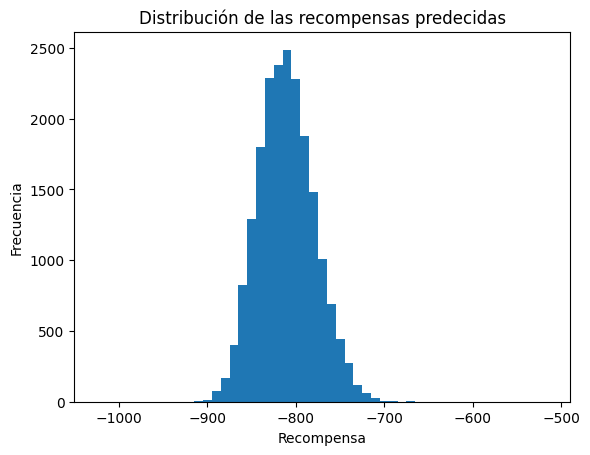

In [203]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards.numpy(), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
#plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [204]:
def ann(x):
    return net.predict_reward(torch.from_numpy(x).float()).detach().numpy()

In [205]:
res = scipy.optimize.minimize(ann, x0=np.zeros(latent_dims))

In [206]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.5596663951873779
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 65
     njev: 1

In [207]:
minimum = torch.from_numpy(res.x)

In [208]:
net.float()

FireAutoencoder_reward(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=1600, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=1600, bias=True)
  (conv1_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_r1): Linear(in_features=64, out_features=128, bias=True)
  (fc_r2): Linear(in_features=128, out_features=64, bias=True)
  (fc_r3): Linear(in_features=64, out_features=32, bias=True)
  (fc_r4): Linear(in_features=32, out_features=1, bias=True)
)

In [209]:
solution = net.decode(minimum.float().unsqueeze(0))

In [210]:
solution

tensor([[[[0.1513, 0.1681, 0.1188, 0.1779, 0.1219, 0.1738, 0.0962, 0.1810,
           0.0910, 0.1776, 0.1087, 0.1487, 0.0955, 0.1496, 0.1750, 0.1794,
           0.1298, 0.1070, 0.0805, 0.2049],
          [0.1738, 0.1956, 0.0831, 0.1237, 0.1708, 0.0638, 0.1336, 0.1839,
           0.1008, 0.0740, 0.1206, 0.2361, 0.1024, 0.1837, 0.2010, 0.1499,
           0.1399, 0.1161, 0.0538, 0.1688],
          [0.1571, 0.0587, 0.0000, 0.0251, 0.0808, 0.0000, 0.0006, 0.1368,
           0.0369, 0.0000, 0.1485, 0.0000, 0.0794, 0.0476, 0.0000, 0.1373,
           0.1200, 0.1099, 0.0284, 0.1465],
          [0.1560, 0.2017, 0.1279, 0.1344, 0.1239, 0.2072, 0.1530, 0.2209,
           0.1416, 0.1614, 0.0402, 0.1237, 0.1986, 0.0886, 0.0241, 0.2528,
           0.0457, 0.1313, 0.1340, 0.1219],
          [0.1665, 0.0587, 0.1129, 0.0000, 0.0621, 0.0000, 0.0111, 0.1104,
           0.0721, 0.1449, 0.0000, 0.0165, 0.1179, 0.0381, 0.0000, 0.1143,
           0.0000, 0.1275, 0.0549, 0.1389],
          [0.1222, 0.1622, 0.1

In [211]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

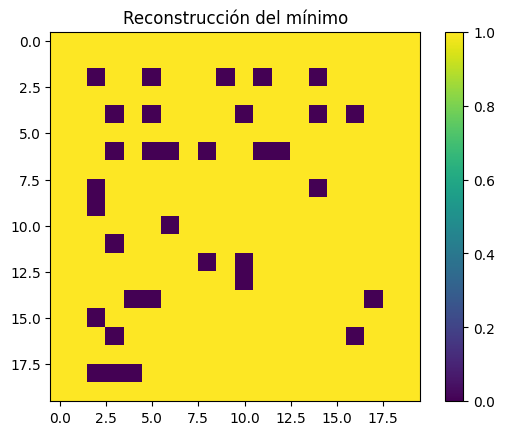

In [212]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.savefig(f"linear_regresion/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [213]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.